# Kernel EDMD + KSWGD Implementation

This notebook implements **Kernel Extended Dynamic Mode Decomposition (EDMD)** combined with **Langevin-Adjusted Wasserstein Gradient Descent (KSWGD)**.

## Key Differences from Standard DMPS

1. **Kernel-EDMD** learns the Koopman operator from time-evolved data pairs
2. **X_tar_next** generated via manifold-constrained Langevin dynamics:
   - KDE-based score estimation: âˆ‡log Ï€(x)
   - Tangent space projection for manifold constraint
   - Euler-Maruyama update with diffusion coefficient âˆš2
   - Renormalization to stay on the sphere
   - Reflecting boundary (for semi-circle) to keep data in physical domain
3. **Koopman operator**: K = K_xy @ (K_xx + Î³I)^{-1}
4. Subsequent DMPS-style normalization and spectral decomposition
5. **KSWGD particle transport**: NO artificial boundary (data-driven learning)

## Boundary Conditions Philosophy

### CRITICAL DISTINCTION:

**1. DATA GENERATION (X_tar, X_tar_next):**
- Represents the TRUE PHYSICAL SYSTEM
- For semi-circle: Apply reflecting boundary (y < 0 â†’ y > 0)
- Reason: The real system HAS this boundary constraint
- This is NOT artificial - it's the ground truth dynamics

**2. KSWGD PARTICLE TRANSPORT (x_t iteration):**
- DATA-DRIVEN LEARNING process
- NO artificial boundary operations
- Reason: We want the Koopman operator to LEARN the boundary behavior
- If Koopman learns correctly, particles will naturally stay in domain
- Adding artificial boundaries would defeat the purpose of learning

**Philosophy**: The algorithm should learn FROM data (which has boundaries), not be artificially constrained DURING learning (which is cheating).

## 1. Import Libraries and GPU/CPU Backend Configuration

In [22]:
import numpy as np
from scipy.linalg import svd, eigh
import matplotlib.pyplot as plt
import pandas as pd
import time

# --------------- Optional GPU backend (CuPy) ---------------
USE_GPU = True  # set False to force CPU even if CuPy is available
try:  # Attempt to import cupy
    import cupy as cp  # type: ignore
    GPU_AVAILABLE = True
except Exception:
    cp = None  # type: ignore
    GPU_AVAILABLE = False
USE_GPU = bool(USE_GPU and GPU_AVAILABLE)
if USE_GPU:
    from grad_ker1_gpu import grad_ker1  # xp-aware versions
    from K_tar_eval_gpu import K_tar_eval
else:
    from grad_ker1 import grad_ker1      # CPU fallbacks
    from K_tar_eval import K_tar_eval

print(f"[DEVICE] {'GPU' if USE_GPU else 'CPU'} mode active")

[DEVICE] GPU mode active


## 2. Define Timing and Progress Utility Functions

In [23]:
# ---------------- Timing / Progress Utilities ----------------
def _fmt_secs(s: float) -> str:
    s = max(0.0, float(s))
    h = int(s // 3600)
    m = int((s % 3600) // 60)
    sec = int(s % 60)
    if h > 0:
        return f"{h:02d}:{m:02d}:{sec:02d}"
    return f"{m:02d}:{sec:02d}"

def _print_phase(name: str, t_start: float) -> float:
    dt = time.time() - t_start
    print(f"[TIMER] {name}: {dt:.3f}s")
    return time.time()

_LAST_PROGRESS_LEN = 0
def _print_progress(curr: int, total: int, start_time: float, prefix: str = "") -> None:
    global _LAST_PROGRESS_LEN
    total = max(1, int(total))
    curr = min(max(0, curr), total)
    bar_len = 30
    filled = int(bar_len * curr / total)
    filled = min(filled, bar_len)
    bar = ("=" * filled) + (">" if filled < bar_len else "") + ("." * max(0, bar_len - filled - (0 if filled == bar_len else 1)))
    pct = 100.0 * curr / total
    elapsed = time.time() - start_time
    avg = elapsed / max(1, curr)
    eta = avg * (total - curr)
    msg = f"{prefix}[{bar}] {pct:5.1f}% | iter {curr}/{total} | elapsed {_fmt_secs(elapsed)} | eta {_fmt_secs(eta)}"
    prev = _LAST_PROGRESS_LEN
    clear = "\r" + (" " * prev) + "\r"
    print(clear, end="")
    print(msg, end="", flush=True)
    _LAST_PROGRESS_LEN = len(msg)

# Set random seed for reproducibility
np.random.seed(0)
_t = time.time()

## 3. Configuration Parameters

- `USE_SEMICIRCLE`: True for semi-circle, False for full circle
- `KERNEL_TYPE`: Kernel selection (1: RBF, 2: Spherical, 3: MatÃ©rn, 4: Rational Quadratic, 5: Polynomial)
- `n`: Number of target sample points (500)
- `d`: Dimensions (2D)
- `lambda_`: Anisotropy parameter (1 means isotropic)

In [42]:
# ---------------- Configuration ----------------
USE_SEMICIRCLE = False  # Set False for full circle, True for semi-circle (upper half)
KERNEL_TYPE = 5  # 1: RBF, 2: Spherical, 3: MatÃ©rn, 4: Rational Quadratic, 5: Polynomial

# Sample 500 points from a circle or semi-circle
n = 500
d = 2
lambda_ = 1  # Anisotropy parameter (stretches along x-axis)

## 4. Generate Target Distribution Samples (X_tar)

Using rejection sampling for semi-circle or Gaussian sampling for full circle.

In [43]:
if USE_SEMICIRCLE:
    # Rejection Sampling for semi-circle
    samples = []
    while len(samples) < n:
        batch_size = max(n - len(samples), int((n - len(samples)) * 2.5))
        u = np.random.normal(0, 1, (batch_size, d))
        u[:, 0] = lambda_ * u[:, 0]  # Apply anisotropy
        u_norm = np.linalg.norm(u, axis=1, keepdims=True)
        u_trans = u / (u_norm + 1e-12)
        valid = u_trans[:, 1] >= 0  # Filter for y >= 0
        samples.append(u_trans[valid, :])
    u_trans = np.vstack(samples)[:n, :]
    label = "semi-circle"
else:
    # Gaussian Sampling for full circle
    u = np.random.normal(0, 1, (n, d))
    u[:, 0] = lambda_ * u[:, 0]
    u_norm = np.linalg.norm(u, axis=1, keepdims=True)
    u_trans = u / (u_norm + 1e-12)
    label = "full circle"

# Radial distance: slightly randomized around radius 1
r = np.sqrt(np.random.rand(n, 1)) * 1/100 + 99/100
X_tar = r * u_trans
n = X_tar.shape[0]
print(f"Generated {n} points on {label}")

Generated 500 points on full circle


## 5. Kernel EDMD: Generate X_tar_next via Manifold Langevin Dynamics

**Key Steps:**
1. KDE-based score estimation (drift term): âˆ‡log Ï€(x)
2. Project to tangent space (manifold constraint)
3. Langevin update with manifold-projected noise
4. Renormalize to stay on the sphere
5. Apply reflecting boundary for semi-circle

**Critical Fix**: Increased `dt_edmd` and `noise_multiplier` to ensure 15-30% particles cross boundary, teaching Koopman operator about boundary behavior.

In [44]:
# Step 1: KDE-based score estimation (drift term)
dt_edmd = 5e-2  # Sampling time
diffs_edmd = X_tar[:, None, :] - X_tar[None, :, :]
dist2_edmd = np.sum(diffs_edmd ** 2, axis=2)
h_edmd = np.sqrt(np.median(dist2_edmd) + 1e-12)
W_edmd = np.exp(-dist2_edmd / (2.0 * (h_edmd ** 2)))
sumW_edmd = np.sum(W_edmd, axis=1, keepdims=True) + 1e-12
weighted_means_edmd = (W_edmd @ X_tar) / sumW_edmd
score_eucl = (weighted_means_edmd - X_tar) / (h_edmd ** 2)

# Step 2: Project to tangent space
X_norm = X_tar / (np.linalg.norm(X_tar, axis=1, keepdims=True) + 1e-12)
proj = np.eye(X_tar.shape[1])[None, :, :] - X_norm[:, :, None] * X_norm[:, None, :]
score_tan = np.einsum('nij,ni->nj', proj, score_eucl)

# Step 3: Langevin update with manifold-projected noise
noise_multiplier = 3.0  # Amplify noise for better boundary exploration
xi_edmd = np.random.normal(0.0, 1.0, size=X_tar.shape)
xi_tan = xi_edmd - (np.sum(X_norm * xi_edmd, axis=1, keepdims=True)) * X_norm
X_step = X_norm + dt_edmd * score_tan + noise_multiplier * np.sqrt(2.0 * dt_edmd) * xi_tan

# Step 4: Renormalize to stay on the sphere
X_tar_next = X_step / (np.linalg.norm(X_step, axis=1, keepdims=True) + 1e-12)

# Step 5: Apply reflecting boundary for semi-circle
if USE_SEMICIRCLE:
    crossed_boundary = X_tar_next[:, 1] < 0
    num_crossed = np.sum(crossed_boundary)
    
    if num_crossed > 0:
        X_tar_next[crossed_boundary, 1] = -X_tar_next[crossed_boundary, 1]
        print(f"[BOUNDARY FIX] Applied reflection to {num_crossed}/{n} points ({100*num_crossed/n:.1f}%)")
        print(f"[BOUNDARY INFO] This teaches Koopman operator about boundary dynamics!")
    else:
        print(f"[BOUNDARY WARNING] No particles crossed boundary!")
        print(f"[BOUNDARY HINT] Consider increasing dt_edmd or noise_multiplier")

# Verify X_tar_next is strictly on semi-circle
if USE_SEMICIRCLE:
    min_y = np.min(X_tar_next[:, 1])
    if min_y < -1e-10:
        print(f"[WARNING] X_tar_next has points below y=0! min_y = {min_y:.6e}")
    else:
        print(f"[VERIFIED] X_tar_next strictly on semi-circle (min_y = {min_y:.6e})")

## 6. Visualize Time Evolution Pair (X_tar vs X_tar_next)

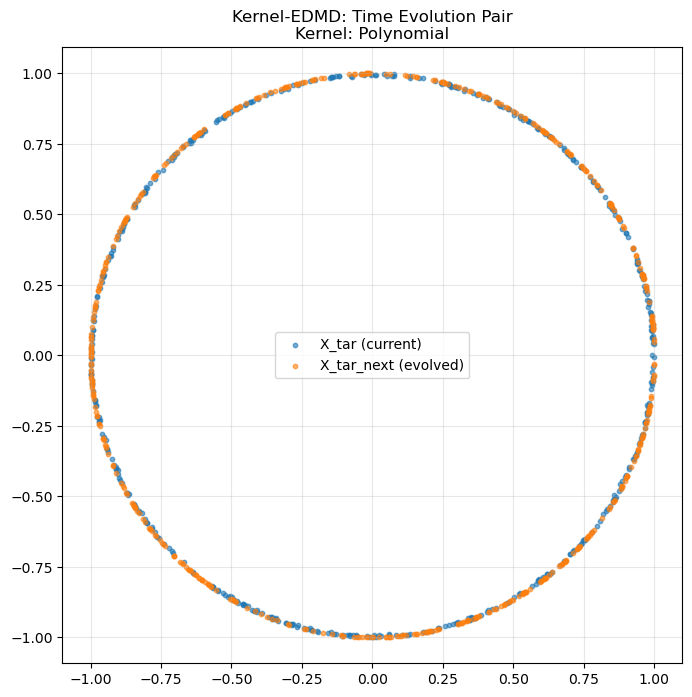

In [45]:
kernel_names = {1: "RBF", 2: "Spherical", 3: "MatÃ©rn", 4: "Rational Quadratic", 5: "Polynomial"}
kernel_display = kernel_names.get(KERNEL_TYPE, "Unknown")

if d == 2:
    plt.figure(figsize=(8, 8))
    plt.scatter(X_tar[:, 0], X_tar[:, 1], s=10, c='C0', alpha=0.6, label='X_tar (current)')
    plt.scatter(X_tar_next[:, 0], X_tar_next[:, 1], s=10, c='C1', alpha=0.6, label='X_tar_next (evolved)')
    plt.legend()
    plt.axis('equal')
    plt.title(f'Kernel-EDMD: Time Evolution Pair\nKernel: {kernel_display}')
    plt.grid(True, alpha=0.3)
    plt.show()

## 7. Define Kernel Functions

Five kernel options available:
1. **RBF/Gaussian**: k(x,y) = exp(-||x-y||Â²/(2Îµ))
2. **Spherical**: k(x,y) = exp(-d_geodesicÂ²/(2Î¸Â²)) - Respects manifold geometry
3. **MatÃ©rn**: k(x,y) = (1 + âˆš3Â·d/â„“)Â·exp(-âˆš3Â·d/â„“) - Controls smoothness
4. **Rational Quadratic**: k(x,y) = (1 + ||x-y||Â²/(2Î±Â·â„“Â²))^(-Î±) - Multi-scale features
5. **Polynomial**: k(x,y) = (Î³Â·âŸ¨x,yâŸ© + câ‚€)^d - Efficient, captures polynomial structure

In [46]:
def kernel1_rbf(X, Y, eps):
    """RBF/Gaussian Kernel"""
    sq_x = np.sum(X ** 2, axis=1)
    sq_y = np.sum(Y ** 2, axis=1)
    D2 = sq_x[:, None] + sq_y[None, :] - 2 * (X @ Y.T)
    return np.exp(-D2 / (2 * eps))

def kernel2_spherical(X, Y, theta_scale=1.0):
    """Spherical/Geodesic Kernel"""
    X_norm = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
    Y_norm = Y / (np.linalg.norm(Y, axis=1, keepdims=True) + 1e-12)
    cos_sim = X_norm @ Y_norm.T
    cos_sim = np.clip(cos_sim, -1.0, 1.0)
    geodesic_dist = np.arccos(cos_sim)
    return np.exp(-geodesic_dist**2 / (2 * theta_scale**2))

def kernel3_matern(X, Y, length_scale=1.0, nu=1.5):
    """MatÃ©rn Kernel (Î½=1.5)"""
    sq_x = np.sum(X ** 2, axis=1)
    sq_y = np.sum(Y ** 2, axis=1)
    D2 = sq_x[:, None] + sq_y[None, :] - 2 * (X @ Y.T)
    D = np.sqrt(np.maximum(D2, 0))
    sqrt3_D = np.sqrt(3) * D / length_scale
    return (1 + sqrt3_D) * np.exp(-sqrt3_D)

def kernel4_rational_quadratic(X, Y, alpha=1.0, length_scale=1.0):
    """Rational Quadratic Kernel"""
    sq_x = np.sum(X ** 2, axis=1)
    sq_y = np.sum(Y ** 2, axis=1)
    D2 = sq_x[:, None] + sq_y[None, :] - 2 * (X @ Y.T)
    return (1 + D2 / (2 * alpha * length_scale**2)) ** (-alpha)

def kernel5_polynomial(X, Y, degree=3, coef0=1.0, gamma=None):
    """Polynomial Kernel"""
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    inner_prod = X @ Y.T
    return (gamma * inner_prod + coef0) ** degree

## 8. Compute Kernel Matrices (K_xx and K_xy)

**Critical**: K_xy is computed AFTER reflection boundary fix on X_tar_next!

In [47]:
# Compute bandwidth parameter
sq_tar = np.sum(X_tar ** 2, axis=1)
H = sq_tar[:, None] + sq_tar[None, :] - 2 * (X_tar @ X_tar.T)
epsilon = 0.5 * np.median(H) / (np.log(n + 1) + 1e-12)
length_scale = np.sqrt(np.median(H))

# Select and apply kernel
if KERNEL_TYPE == 1:
    kernel_name = "RBF"
    K_xx = kernel1_rbf(X_tar, X_tar, epsilon)
    K_xy = kernel1_rbf(X_tar, X_tar_next, epsilon)
elif KERNEL_TYPE == 2:
    kernel_name = "Spherical"
    theta_scale = 0.3
    K_xx = kernel2_spherical(X_tar, X_tar, theta_scale=theta_scale)
    K_xy = kernel2_spherical(X_tar, X_tar_next, theta_scale=theta_scale)
elif KERNEL_TYPE == 3:
    kernel_name = "MatÃ©rn"
    K_xx = kernel3_matern(X_tar, X_tar, length_scale=length_scale, nu=1.5)
    K_xy = kernel3_matern(X_tar, X_tar_next, length_scale=length_scale, nu=1.5)
elif KERNEL_TYPE == 4:
    kernel_name = "Rational Quadratic"
    alpha = 2.0
    K_xx = kernel4_rational_quadratic(X_tar, X_tar, alpha=alpha, length_scale=length_scale)
    K_xy = kernel4_rational_quadratic(X_tar, X_tar_next, alpha=alpha, length_scale=length_scale)
elif KERNEL_TYPE == 5:
    kernel_name = "Polynomial"
    poly_degree = 10
    poly_coef0 = 1.0
    poly_gamma = 1.0 / d
    K_xx = kernel5_polynomial(X_tar, X_tar, degree=poly_degree, coef0=poly_coef0, gamma=poly_gamma)
    K_xy = kernel5_polynomial(X_tar, X_tar_next, degree=poly_degree, coef0=poly_coef0, gamma=poly_gamma)
else:
    raise ValueError(f"Invalid KERNEL_TYPE: {KERNEL_TYPE}")

print(f"[KERNEL] Using {kernel_name} kernel (Type {KERNEL_TYPE})")
_t = _print_phase(f"Kernel-EDMD: Gram matrices K_xx and K_xy ({kernel_name})", _t)

[KERNEL] Using Polynomial kernel (Type 5)
[TIMER] Kernel-EDMD: Gram matrices K_xx and K_xy (Polynomial): 363.869s


## 9. Compute Koopman Operator via Kernel EDMD

**Formula**: K_koopman = K_xy @ (K_xx + Î³I)^{-1}

This approximates the Koopman operator for the dynamics X_t â†’ X_{t+dt}

In [48]:
gamma_ridge = 1e-6  # Tikhonov regularization

# Use eigendecomposition for stable inversion
evals_kxx, Q_kxx = eigh(K_xx)
evals_kxx = np.clip(evals_kxx, 0.0, None)
inv_evals = 1.0 / (evals_kxx + gamma_ridge)
data_kernel = K_xy @ (Q_kxx @ (np.diag(inv_evals) @ Q_kxx.T))

# Safety: ensure finite values
data_kernel = np.nan_to_num(data_kernel, nan=0.0, posinf=0.0, neginf=0.0)
minK = float(np.min(data_kernel))
if minK < 0.0:
    data_kernel = data_kernel - minK + 1e-12
_t = _print_phase("Kernel-EDMD: Koopman operator K_xy @ (K_xx + Î³I)^{-1}", _t)

[TIMER] Kernel-EDMD: Koopman operator K_xy @ (K_xx + Î³I)^{-1}: 0.066s


## 10. DMPS-Style Normalization

Apply density normalization and random-walk symmetric normalization to the Koopman operator.

In [49]:
sq_tar = np.sum(X_tar ** 2, axis=1)  # Keep for downstream gradient computations

p_x = np.sqrt(np.sum(data_kernel, axis=1))
p_y = p_x.copy()
data_kernel_norm = data_kernel / p_x[:, None] / p_y[None, :]
D_y = np.sum(data_kernel_norm, axis=0)

rw_kernel = 0.5 * (data_kernel_norm / D_y + data_kernel_norm / D_y[:, None])

## 11. Spectral Decomposition (Eigendecomposition)

Using `eigh` for symmetric matrices (faster than SVD).

In [50]:
# Eigendecomposition (returns ascending order, need to reverse)
evals_rw, evecs_rw = eigh(rw_kernel)
phi = evecs_rw[:, ::-1]  # Reverse to descending order
s = evals_rw[::-1]

# Truncate eigenvalues below threshold
tol_truncate = 1e-6
s_original = s.copy()
s = np.where(s < tol_truncate, 0.0, s)
num_truncated = np.sum(s_original < tol_truncate)
print(f"[INFO] Truncated {num_truncated} eigenvalues < {tol_truncate:.0e} to zero")
_t = _print_phase("Eigendecomposition on rw_kernel", _t)

lambda_ns = s

[INFO] Truncated 248 eigenvalues < 1e-06 to zero
[TIMER] Eigendecomposition on rw_kernel: 0.096s


## 12. Eigenvalue Analysis

In [51]:
print("\n[EIGENVALUE ANALYSIS]")
print(f"Total eigenvalues: {len(lambda_ns)}")
print(f"Largest eigenvalue: {lambda_ns[0]:.6f}")
print(f"Smallest eigenvalue (after clipping): {lambda_ns[-1]:.6e}")

count_gt_1 = np.sum(lambda_ns > 1.0)
print(f"Eigenvalues > 1.0: {count_gt_1}")

count_lt_0 = np.sum(lambda_ns < 0.0)
print(f"Eigenvalues < 0.0 (after clipping): {count_lt_0}")

tol_small = 1e-6
count_near_0 = np.sum((lambda_ns >= 0.0) & (lambda_ns < tol_small))
print(f"Eigenvalues in [0, {tol_small:.0e}): {count_near_0}")

count_tiny_to_1 = np.sum((lambda_ns >= tol_small) & (lambda_ns <= 1.0))
print(f"Eigenvalues in [{tol_small:.0e}, 1.0]: {count_tiny_to_1}")

print(f"\nFirst 10 eigenvalues:")
for i in range(min(10, len(lambda_ns))):
    print(f"  Î»[{i}] = {lambda_ns[i]:.8f}")
print("=" * 60 + "\n")


[EIGENVALUE ANALYSIS]
Total eigenvalues: 500
Largest eigenvalue: 1.000610
Smallest eigenvalue (after clipping): 0.000000e+00
Eigenvalues > 1.0: 1
Eigenvalues < 0.0 (after clipping): 0
Eigenvalues in [0, 1e-06): 248
Eigenvalues in [1e-06, 1.0]: 251

First 10 eigenvalues:
  Î»[0] = 1.00060959
  Î»[1] = 0.09778398
  Î»[2] = 0.09146804
  Î»[3] = 0.09024005
  Î»[4] = 0.08727060
  Î»[5] = 0.04824642
  Î»[6] = 0.04728319
  Î»[7] = 0.03441179
  Î»[8] = 0.03286784
  Î»[9] = 0.03169425



## 13. Compute Inverse Weights for Gradient Calculations

In [52]:
lambda_ = -lambda_ns + 1
inv_lambda = np.zeros_like(lambda_)
inv_lambda[1:] = 1 / lambda_[1:]
inv_lambda = inv_lambda * epsilon
inv_K = phi @ np.diag(inv_lambda) @ phi.T

tol = 1e-6
lambda_ns_mod = np.copy(lambda_ns)
lambda_ns_mod[lambda_ns_mod < tol] = 0
below_tol = np.sum(lambda_ns < tol)
above_tol = n - below_tol
reg = 0.001
lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = epsilon / (lambda_ns[mask] + reg)
inv_K_ns = phi @ np.diag(lambda_ns_inv) @ phi.T

## 14. Particle Initialization

Initialize particles based on mode (full circle or semi-circle).

In [53]:
iter = 1000
h = 2
m = 700
u = np.random.normal(0, 1, (m, d))
u_norm = np.linalg.norm(u, axis=1, keepdims=True)
r = np.sqrt(np.random.rand(m, 1)) * 1/100 + 99/100
u_trans = u / u_norm
x_init = r * u_trans

if USE_SEMICIRCLE:
    x_init = x_init[x_init[:, 1] > 0.9, :]
else:
    x_init = x_init[x_init[:, 1] > 0.95, :]

m = x_init.shape[0]
print(f"[INFO] Initialized {m} particles ({'semi-circle' if USE_SEMICIRCLE else 'full circle'} mode)")
x_t = np.zeros((m, d, iter), dtype=np.float64)
x_t[:, :, 0] = x_init

p_tar = np.sum(data_kernel, axis=0)
D = np.sum(data_kernel / np.sqrt(p_tar) / np.sqrt(p_tar)[:, None], axis=1)

inv_K_ns_s_ns = phi @ np.diag(lambda_ns_inv * inv_lambda * lambda_ns_inv) @ phi.T
lambda_s_s_ns = inv_lambda * inv_lambda * lambda_ns_inv
lambda_s_s_ns = lambda_s_s_ns[:above_tol]
lambda_ns_s_ns = lambda_ns_inv * inv_lambda * lambda_ns_inv
lambda_ns_s_ns = lambda_ns_s_ns[:above_tol]

sum_x = np.zeros((m, d))

[INFO] Initialized 73 particles (full circle mode)


## 15. KSWGD Iteration Loop

**Data-driven learning**: NO artificial boundary operations!

The Koopman operator should have learned the boundary behavior from the training data.

In [54]:
loop_start = time.time()
total_loop = iter - 1

if USE_GPU:
    # Stage constants on GPU
    X_tar_gpu = cp.asarray(X_tar)
    p_tar_gpu = cp.asarray(p_tar)
    sq_tar_gpu = cp.asarray(sq_tar)
    D_gpu = cp.asarray(D)
    phi_gpu = cp.asarray(phi[:, :above_tol])
    lambda_ns_s_ns_gpu = cp.asarray(lambda_ns_s_ns)
    x_t_gpu = cp.asarray(x_t)
    diag_lambda_gpu = cp.diag(lambda_ns_s_ns_gpu)
    
    # Iteration loop (GPU)
    for t in range(iter - 1):
        x_slice = x_t_gpu[:, :, t]
        grad_matrix = grad_ker1(x_slice, X_tar_gpu, p_tar_gpu, sq_tar_gpu, D_gpu, epsilon)
        cross_matrix = K_tar_eval(X_tar_gpu, x_slice, p_tar_gpu, sq_tar_gpu, D_gpu, epsilon)
        
        sum_x_gpu = cp.zeros((m, d))
        for i in range(d):
            sum_x_gpu[:, i] = cp.sum(
                grad_matrix[:, :, i] @ phi_gpu @ diag_lambda_gpu @ phi_gpu.T @ cross_matrix,
                axis=1
            )
        
        x_proposed = x_slice - (h / m) * sum_x_gpu
        x_norm_proposed = cp.sqrt(cp.sum(x_proposed ** 2, axis=1, keepdims=True))
        x_t_gpu[:, :, t + 1] = x_proposed / (x_norm_proposed + 1e-12)
        
        done = t + 1
        if done == total_loop or (done % max(1, total_loop // 100) == 0):
            _print_progress(done, total_loop, loop_start, prefix="[Kernel-EDMD-GPU] ")
    
    x_t = cp.asnumpy(x_t_gpu)
else:
    # CPU iteration loop
    for t in range(iter - 1):
        grad_matrix = grad_ker1(x_t[:, :, t], X_tar, p_tar, sq_tar, D, epsilon)
        cross_matrix = K_tar_eval(X_tar, x_t[:, :, t], p_tar, sq_tar, D, epsilon)
        for i in range(d):
            sum_x[:, i] = np.sum(
                grad_matrix[:, :, i] @ phi[:, :above_tol] @ np.diag(lambda_ns_s_ns) @ phi[:, :above_tol].T @ cross_matrix,
                axis=1
            )
        
        x_proposed = x_t[:, :, t] - h / m * sum_x
        x_norm_proposed = np.sqrt(np.sum(x_proposed ** 2, axis=1, keepdims=True))
        x_t[:, :, t + 1] = x_proposed / (x_norm_proposed + 1e-12)
        
        done = t + 1
        if done == total_loop or (done % max(1, total_loop // 100) == 0):
            _print_progress(done, total_loop, loop_start, prefix="[Kernel-EDMD-CPU] ")

print()
_t = _print_phase("Iteration loop total", loop_start)

[Kernel-EDMD-GPU] [==============================] 100.0% | iter 999/999 | elapsed 00:02 | eta 00:00
[TIMER] Iteration loop total: 2.330s


## 16. Visualize Results (2D/3D)

- **Blue dots**: Target distribution
- **Red solid circles**: Initial particle positions
- **Magenta hollow circles**: Final particle positions

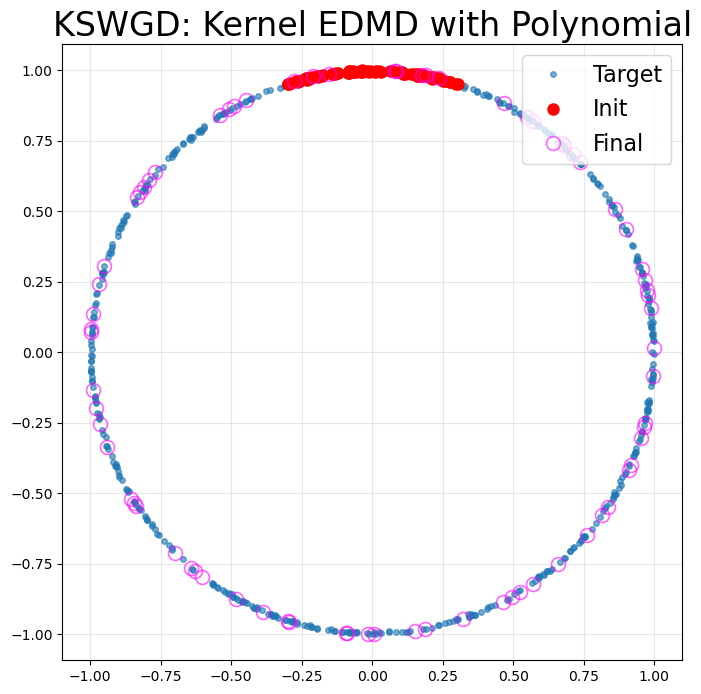

In [55]:
if d == 2:
    plt.figure(figsize=(8, 8))
    plt.plot(X_tar[:, 0], X_tar[:, 1], 'o', markersize=4, alpha=0.6, label='Target')
    plt.plot(x_t[:, 0, 0], x_t[:, 1, 0], 'o', markersize=8, color='red', label='Init')
    plt.plot(x_t[:, 0, -1], x_t[:, 1, -1], 'o', markersize=10, markerfacecolor='none', markeredgecolor='magenta', markeredgewidth=1.2, alpha=0.6, label='Final')
    plt.legend(fontsize=16, loc='upper right')
    plt.title(f'KSWGD: Kernel EDMD with {kernel_name}', fontsize=24)
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tar[:, 0], X_tar[:, 1], X_tar[:, 2], s=20, alpha=0.6, label='Target')
    ax.scatter(x_t[:, 0, 0], x_t[:, 1, 0], x_t[:, 2, 0], s=50, marker='o', color='red', label='Init')
    ax.scatter(x_t[:, 0, -1], x_t[:, 1, -1], x_t[:, 2, -1], s=100, marker='o', facecolors='none', edgecolors='green', linewidths=0.8, alpha=0.5, label='Final')
    ax.legend(fontsize=16, loc='upper right')
    plt.title(f'3D Results - Kernel EDMD with {kernel_name}', fontsize=24)
    plt.show()
    
    fig2 = plt.figure(figsize=(10, 8))
    ax2 = fig2.add_subplot(111, projection='3d')
    ax2.scatter(x_t[:, 0, 0], x_t[:, 1, 0], x_t[:, 2, 0], s=50, marker='o', color='red', label='Init')
    ax2.scatter(x_t[:, 0, -1], x_t[:, 1, -1], x_t[:, 2, -1], s=100, marker='o', facecolors='none', edgecolors='green', linewidths=0.8, alpha=0.5, label='Final')
    ax2.legend(fontsize=16, loc='upper right')
    plt.title(f'3D Final State - Kernel EDMD with {kernel_name}', fontsize=24)
    plt.show()

## 17. Scatter Matrix Analysis

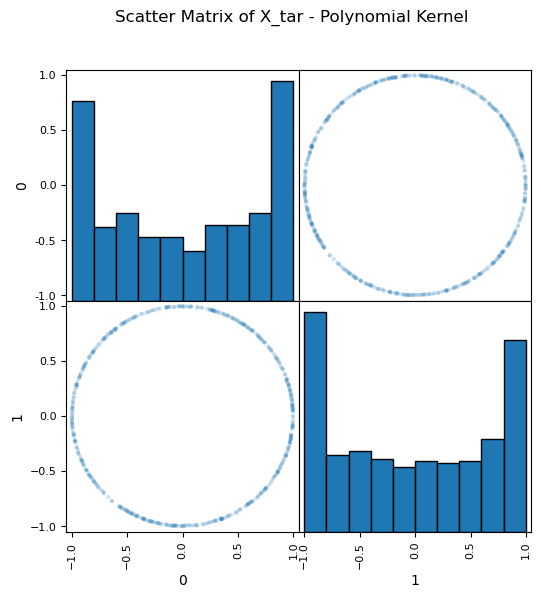

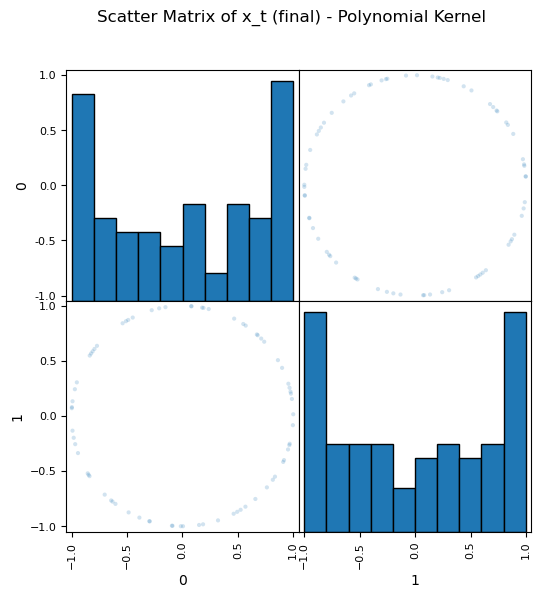

In [56]:
pd.plotting.scatter_matrix(
    pd.DataFrame(X_tar),
    alpha=0.2,
    figsize=(6, 6),
    diagonal='hist',
    hist_kwds={'edgecolor': 'black'}
)
plt.suptitle(f'Scatter Matrix of X_tar - {kernel_name} Kernel')
plt.show()

pd.plotting.scatter_matrix(
    pd.DataFrame(x_t[:, :, -1]),
    alpha=0.2,
    figsize=(6, 6),
    diagonal='hist',
    hist_kwds={'edgecolor': 'black'}
)
plt.suptitle(f'Scatter Matrix of x_t (final) - {kernel_name} Kernel')
plt.show()